In [66]:
import numpy as np
from numpy import *
import scipy.io
import struct

import csv
import numpy
import ipyvolume as ipv
from scipy import interpolate
#from scipy import special
#import matplotlib
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter


In [67]:
#set model parameters

def setmodelparams():
    pardict={}
    pardict["nx"]=20
    pardict["ny"]=20

    pardict["xmax"]=1.0
    pardict["xmin"]=-1.0
    pardict["ymax"]=1.0
    pardict["ymin"]=-1.0
    pardict["dt"]=0.1

    pardict["delx"]=(pardict["xmax"]-pardict["xmin"])/pardict["nx"]
    pardict["dely"]=(pardict["ymax"]-pardict["ymin"])/pardict["ny"]
    pardict["nc"]=1 #number of charges
    return pardict

In [68]:
#set model constants
ep0=8.854188e-12
c=3.0e8

In [69]:
#modelparams

pars=setmodelparams()
nx=pars["nx"]
ny=pars["ny"]

xmax=pars["xmax"]
xmin=pars["xmin"]
ymax=pars["ymax"]
ymin=pars["ymin"]

delx=pars["delx"]
dely=pars["dely"]

nc=pars["nc"]

delt=pars["dt"]   #0.1

In [70]:
#charge positions
xp=np.zeros(nc)
yp=np.zeros(nc)
vxp=np.zeros(nc)
vyp=np.zeros(nc)
vmag=np.zeros(nc)
omeg=np.zeros(nc)
qp=np.zeros(nc)

#create fields
potential = np.zeros( (nx,ny) ); #scalar potential
ex = np.zeros( (nx,ny) ); # electric field x
ey = np.zeros(  (nx,ny)  ); #electric field y 

In [71]:
#set the charge positions
xp[0]=delx/2   #at cell centre not the grid cell
yp[0]=dely/2

vmag[0]=0.2  #this is in units of c
vyp[0]=np.sin(np.pi/4)
vxp[0]=np.cos(np.pi/4)

omeg[0]=0.5
qp[0]=1.0  #this is the charge divided by 4pi epsilon0



In [72]:
cdat={}
cdat["xp"]=xp
cdat["yp"]=yp
cdat["vmag"]=vmag
cdat["vxp"]=vxp
cdat["vyp"]=vyp
cdat["omeg"]=omeg
cdat["q"]=qp

In [73]:
t=0.3 #current time
for i in range(0,nx-1):
    for j in range(0,ny-1):
        #intiailise potential and field because these are computed for each charge
        fpot=0.0
        ext=0
        eyt=0
        for ic in range(0,nc):
            #compute field position
            x=xmin+delx*i
            y=ymin+dely*j
            #calculate change in charge position
            dx=delt*vxp[ic]*np.sin(omeg[ic]*t)
            dy=delt*vyp[ic]*np.sin(omeg[ic]*t)
            xp[ic]=xp[ic]+dx
            yp[ic]=yp[ic]+dy
            r12x=x-xp[ic]
            r12y=y-yp[ic]
            r12mag=np.sqrt(r12x*r12x+r12y*r12y)
            # compute component of velocity along field direction i.e. we use the vector dot product
            vrdash=vmag[ic]*(r12x*vxp[ic]+r12y*vyp[ic])/r12mag
            # compute potential
            fpot=fpot+((qp[ic]/r12mag)*(1/(1-vrdash)))
        potential[i][j]=fpot

#compute the fields
for i in range(0,nx-1):
    for j in range(0,ny-1):        
        #compute gradient (and field using central difference) if boundary assume 0 (charges always in middle of our large grid)
        #
        if i == 0:
            ex[i][j]=(potential[i+1][j])/delx
        elif i==nx-1:
            ex[i][j]=(-potential[i-1][j])/delx
        else:
            ex[i][j]=(potential[i+1][j]-potential[i-1][j])/delx
            
        if j == 0:
            ey[i][j]=(potential[i][j+1])/dely 
        elif j  == ny-1:   
            ey[i][j]=(-potential[i][j-1])/dely
        else:
            ey[i][j]=(potential[i][j+1]-potential[i][j-1])/dely
            

            
            

In [75]:
print(potential)
#print(ex)

[[0.55560443 0.57648465 0.59766237 0.61886549 0.63974868 0.65989331
  0.67881616 0.69598945 0.71087327 0.72295866 0.73181609 0.73714103
  0.73878725 0.73678068 0.73131089 0.7227032  0.71137823 0.69780765
  0.68247354 0.        ]
 [0.48610552 0.50281891 0.51990521 0.53722924 0.55461532 0.57184369
  0.58864949 0.60472573 0.61973141 0.6333058  0.64508883 0.65474602
  0.66199549 0.66663266 0.66854875 0.66773957 0.66430301 0.65842634
  0.65036584 0.        ]
 [0.43163762 0.44523801 0.45919302 0.47343242 0.48786341 0.5023677
  0.51679923 0.53098323 0.54471704 0.55777365 0.56990816 0.5808677
  0.59040432 0.59829007 0.60433264 0.6083896  0.61037918 0.61028591
  0.6081603  0.        ]
 [0.38790803 0.39915167 0.41070596 0.42253295 0.43458173 0.44678651
  0.4590648  0.47131598 0.48342049 0.49524003 0.50661901 0.51738767
  0.52736701 0.53637559 0.54423788 0.55079361 0.55590729 0.55947676
  0.56143973 0.        ]
 [0.35208211 0.36151191 0.37120584 0.38114272 0.39129368 0.40162093
  0.41207653 0.422

In [59]:
#function to update the electric field and the potential
def updatefields(t,pars,cdat,opotential,oex,oey):
    #extract modelpars from  modelpars
    nx=pars["nx"]
    ny=pars["ny"]
    
    xmax=pars["xmax"]
    xmin=pars["xmin"]
    ymax=pars["ymax"]
    ymin=pars["ymin"]
    
    delx=pars["delx"]
    dely=pars["dely"]
    
    delt=pars["dt"]   #0.1

    #extract chargedat from chargedat
    xp=cdat["xp"]
    yp=cdat["yp"]
    vmag=cdat["vmag"]
    vxp=cdat["vxp"]
    vyp=cdat["vyp"]
    omeg=cdat["omeg"]
    qp=cdat["q"]

    
    for i in range(0,nx-1):
        for j in range(0,ny-1):
            #intiailise potential and field because these are computed for each charge
            fpot=0.0
            #ex=0
            #ey=0
            for ic in range(0,nc):
                #compute field position
                x=xmin+delx*i
                y=ymin+dely*j
                #calculate change in charge position
                dx=delt*vxp[ic]*np.sin(omeg[ic]*t)
                dy=delt*vyp[ic]*np.sin(omeg[ic]*t)
                xp[ic]=xp[ic]+dx
                yp[ic]=yp[ic]+dy
                r12x=x-xp[ic]
                r12y=y-yp[ic]
                r12mag=np.sqrt(r12x*r12x+r12y*r12y)
                # compute component of velocity along field direction i.e. we use the vector dot product
                vrdash=vmag[ic]*(r12x*vxp[ic]+r12y*vyp[ic])/r12mag
                # compute potential
                fpot=fpot+((qp[ic]/r12mag)*(1/(1-vrdash)))
            potential[i][j]=fpot
    
    #compute the fields
    for i in range(0,nx-1):
        for j in range(0,ny-1):        
            #compute gradient (and field using central difference) if boundary assume 0 (charges always in middle of our large grid)
            #
            if i == 0:
                ex[i][j]=(potential[i+1][j])/delx
            elif i==nx-1:
                ex[i][j]=(-potential[i-1][j])/delx
            else:
                ex[i][j]=(potential[i+1][j]-potential[i-1][j])/delx
                
            if j == 0:
                ey[i][j]=(potential[i][j+1])/dely 
            elif j  == ny-1:   
                ey[i][j]=(-potential[i][j-1])/dely
            else:
                ey[i][j]=(potential[i][j+1]-potential[i][j-1])/dely


    return potential,ex,ey

In [60]:
t=0.1
pars=setmodelparams()

cdat["xp"]=xp
cdat["yp"]=yp
cdat["vmag"]=vmag
cdat["vxp"]=vxp
cdat["vyp"]=vyp
cdat["omeg"]=omeg
cdat["q"]=qp

potential,ex,ey=updatefields(t,pars,cdat,potential,ex,ey)

In [89]:
print(ey)

[[ 5.76484648e+00  4.20579428e-01  4.23808431e-01  4.20863041e-01
   4.10278148e-01  3.90674826e-01  3.60961431e-01  3.20571074e-01
   2.69692069e-01  2.09428257e-01  1.41823738e-01  6.97116197e-02
  -3.60351631e-03 -7.47636476e-02 -1.40774801e-01 -1.99326587e-01
  -2.48955500e-01 -2.89046913e-01 -6.97807648e+00  0.00000000e+00]
 [ 5.02818915e+00  3.37996919e-01  3.44103231e-01  3.47101071e-01
   3.46144482e-01  3.40341739e-01  3.28820435e-01  3.10819134e-01
   2.85800747e-01  2.53574224e-01  2.14402198e-01  1.69066607e-01
   1.18866311e-01  6.55326646e-02  1.10691259e-02 -4.24574965e-02
  -9.31323257e-02 -1.39371615e-01 -6.58426335e+00  0.00000000e+00]
 [ 4.45238014e+00  2.75554016e-01  2.81944058e-01  2.86703924e-01
   2.89352813e-01  2.89358214e-01  2.86155259e-01  2.79178077e-01
   2.67904235e-01  2.51911201e-01  2.30940520e-01  2.04961597e-01
   1.74223672e-01  1.39283129e-01  1.00995280e-01  6.04654855e-02
   1.89631592e-02 -2.21888780e-02 -6.10285913e+00  0.00000000e+00]
 [ 3.99

-1.0 1.0 0.1 (21,) (20, 20)


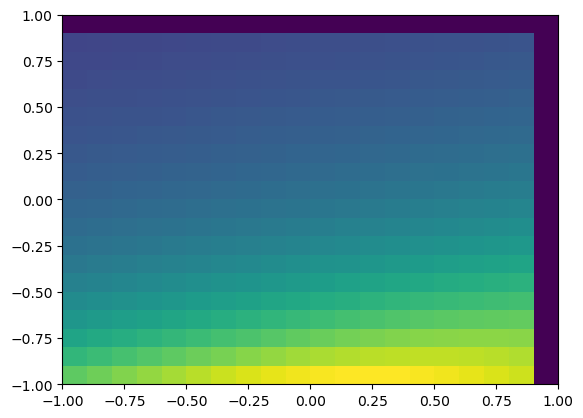

In [91]:
fig, ax = plt.subplots()
Z=potential
x=np.arange(start=xmin, stop=xmax+delx, step=delx)
y=np.arange(start=ymin, stop=ymax+dely, step=dely)

print(xmin,xmax,delx,np.shape(x),np.shape(Z))
ax.pcolormesh(x, y, Z, shading='flat', vmin=Z.min(), vmax=Z.max())

[0 1 2 3 4 5] [0 1 2 3] (6,) (4,) (3, 5)


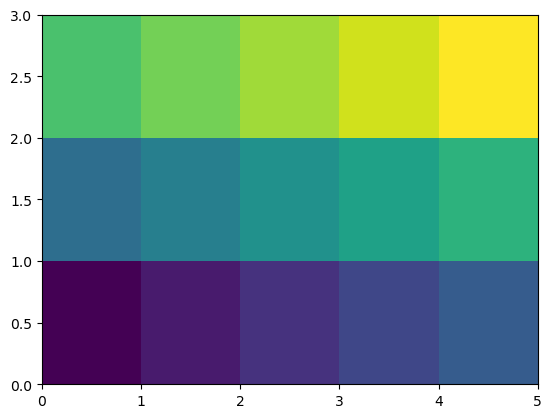

In [92]:
nrows = 3
ncols = 5
#print(np.shape())
Z = np.arange(nrows * ncols).reshape(nrows, ncols)
x = np.arange(ncols + 1)
y = np.arange(nrows + 1)

print(x,y,np.shape(x),np.shape(y),np.shape(Z))

fig, ax = plt.subplots()
ax.pcolormesh(x, y, Z, shading='flat', vmin=Z.min(), vmax=Z.max())

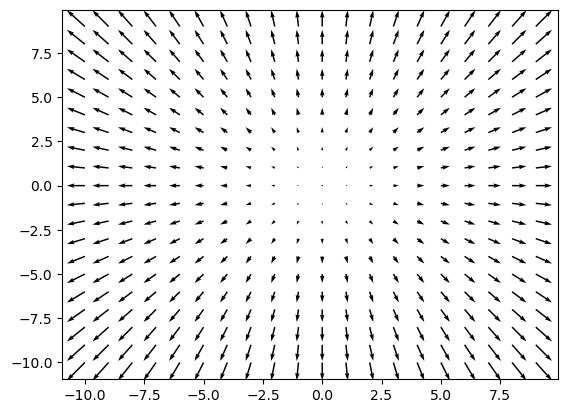

In [22]:
#use matplotlib quiver plot
import matplotlib.pyplot as plt
import numpy as np

X = np.arange(-10, 10, 1)
Y = np.arange(-10, 10, 1)
U, V = np.meshgrid(X, Y)

fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V)
ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Quiver key, length = 10', labelpos='E')

plt.show()

In [2]:
import numpy as np
import ipyvolume as ipv

# Spatial grid
u = np.linspace(-1, 1, 32)
x, y = np.meshgrid(u, u)
x = x.flatten()
y = y.flatten()


In [3]:
# Time evolution
timesteps = 20
r = np.sqrt(x**2 + y**2)

ex_sequence = np.array([np.cos(r + t) for t in np.linspace(0, 2*np.pi, timesteps)])
ey_sequence = np.array([np.sin(r + t) for t in np.linspace(0, 2*np.pi, timesteps)])

In [6]:
def exeyupdate(t, x, y):
    r = np.sqrt(x**2 + y**2)
    ex = np.cos(r + t)
    ey = np.sin(r + t)
    return ex, ey


In [7]:
timesteps = 20
xgrid, ygrid = np.meshgrid(np.linspace(-1, 1, 32), np.linspace(-1, 1, 32))
x = xgrid.flatten()
y = ygrid.flatten()

ex_sequence = []
ey_sequence = []

for t in np.linspace(0, 2*np.pi, timesteps):
    ex, ey = exeyupdate(t, x, y)
    ex_sequence.append(ex)
    ey_sequence.append(ey)

ex_sequence = np.array(ex_sequence)
ey_sequence = np.array(ey_sequence)


In [8]:
ipv.figure()
q = ipv.quiver(x, y, np.zeros_like(x),  # positions
               ex_sequence, ey_sequence, np.zeros_like(ex_sequence),  # vectors
               size=5, color='blue')

ipv.animation_control(q, interval=200)
ipv.show()

Container(children=[HBox(children=(Play(value=0, interval=200, max=19), IntSlider(value=0, max=19)))], figure=…